## 📊 Introduction

The goal of this project is to analyze happiness scores across different countries over the years and identify which factors most strongly influence national well-being. By understanding which elements contribute positively or negatively to happiness—such as economic indicators, health, governance, and social support—we can help inform future policies and strategic planning aimed at improving quality of life globally.

## Steps Followed

- Data Exploration & Cleaning – Checked for missing values, handled inconsistencies, and prepared the dataset for analysis.

- Exploratory Data Analysis (EDA) – Examined trends over time and across regions, computed correlations between happiness and other factors, and visualized key insights through heatmaps and scatter plots.

- Data Visualization – Created global choropleth maps and line charts to showcase geographic and temporal patterns in happiness.

- Model Training – Built and evaluated predictive models (Linear Regression, XGBoost) to quantify which factors have the strongest impact on happiness scores.

- Conclusion & Insights – Summarized findings, highlighting that economic prosperity, health, and social support contribute most positively to happiness, while perceptions of corruption tend to lower it.


## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [1]:
!pip install optuna
!pip install xgboost



In [2]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import plotly.express as px

import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import torch
from torch import nn

In [3]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [4]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [5]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
411,China,2011,5.037,9.178,0.787,66.96,0.824,-0.192,NaN,0.710,0.134
1342,Mauritius,2011,5.477,9.797,0.800,63.52,0.848,0.184,0.847,0.653,0.253
1573,North Macedonia,2015,4.976,9.625,0.766,65.30,0.660,-0.053,0.824,0.551,0.299
1326,Malta,2023,6.295,NaN,0.912,71.70,0.851,NaN,0.780,0.644,0.361
1257,Madagascar,2016,3.663,7.332,0.746,56.55,0.570,-0.072,0.864,0.670,0.204


In [6]:
world_happiness_df.columns

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect'],
      dtype='object')

Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [7]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [8]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [9]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [10]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [11]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


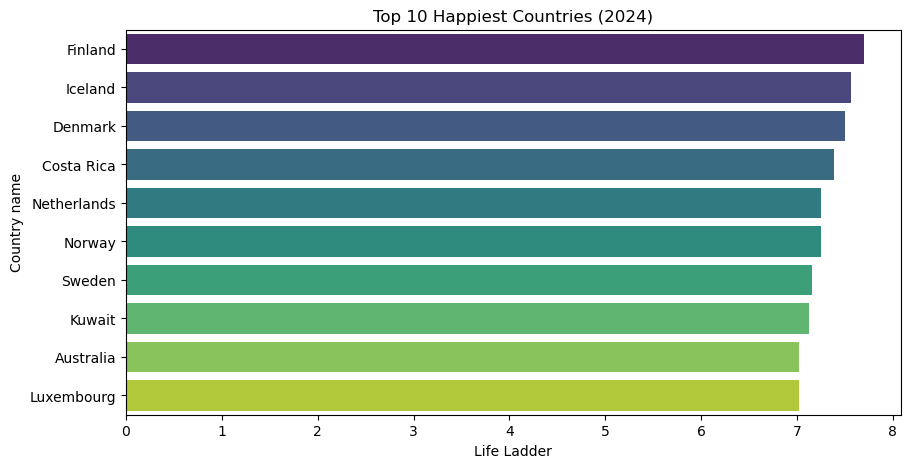

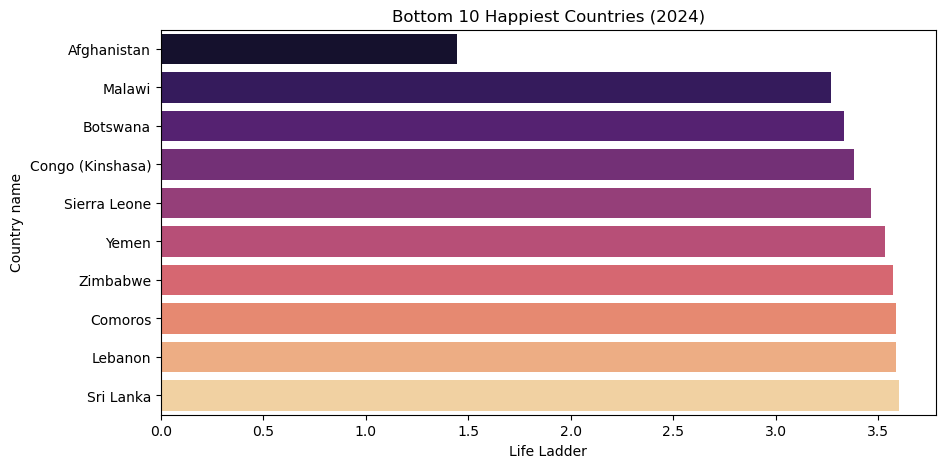

In [12]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

In [13]:
df_2020 = df[df["year"] == 2020].copy()

#  Basic validation
print(f"Number of countries in 2020 data: {df_2020['Country name'].nunique()}")

#  Create choropleth map
fig = px.choropleth(
    df_2020,
    locations="Country name",             # column with country names
    locationmode="country names",         # match on country names
    color="Life Ladder",                  # main happiness score
    hover_name="Country name",            # show country on hover
    hover_data={
        "Life Ladder": ":.2f",
        "Log GDP per capita": ":.2f",
        "Social support": ":.2f",
        "Healthy life expectancy at birth": ":.2f",
        "Freedom to make life choices": ":.2f",
        "Generosity": ":.2f",
        "Perceptions of corruption": ":.2f"
    },
    color_continuous_scale="YlGnBu",      # pleasant blue-green palette
    title="🌍 World Happiness Map — 2020 (Life Ladder Score)"
)

#  Customize layout
fig.update_layout(
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Happiness (0–10)")
)

#  Display
fig.show()

Number of countries in 2020 data: 116


### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


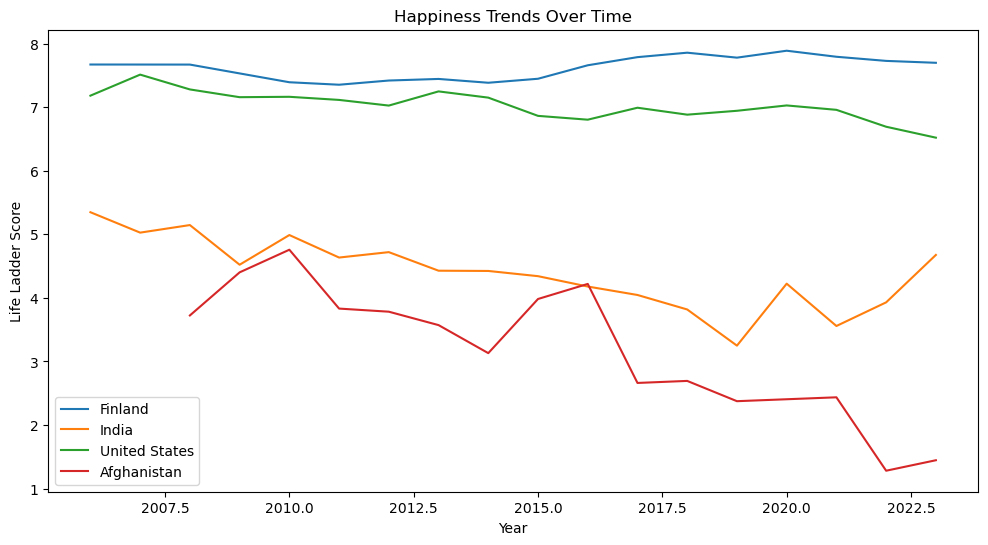

In [14]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


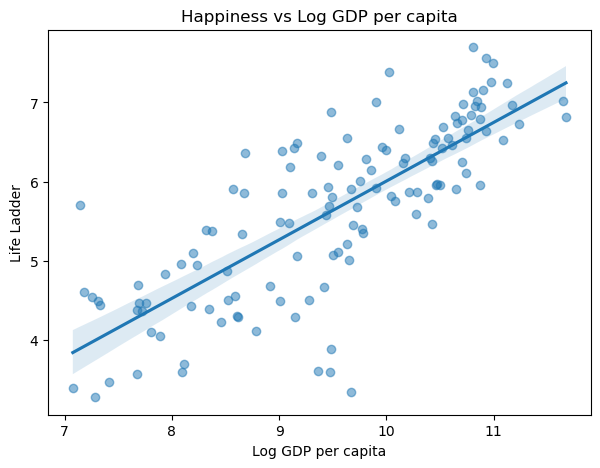

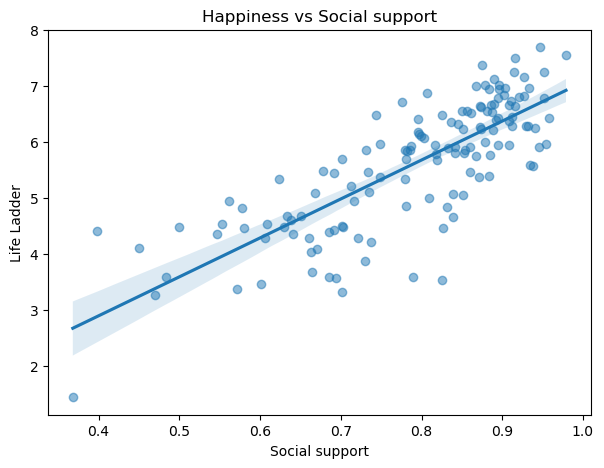

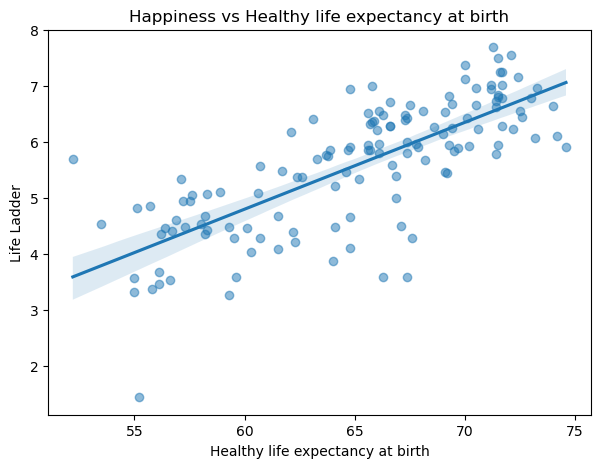

In [15]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


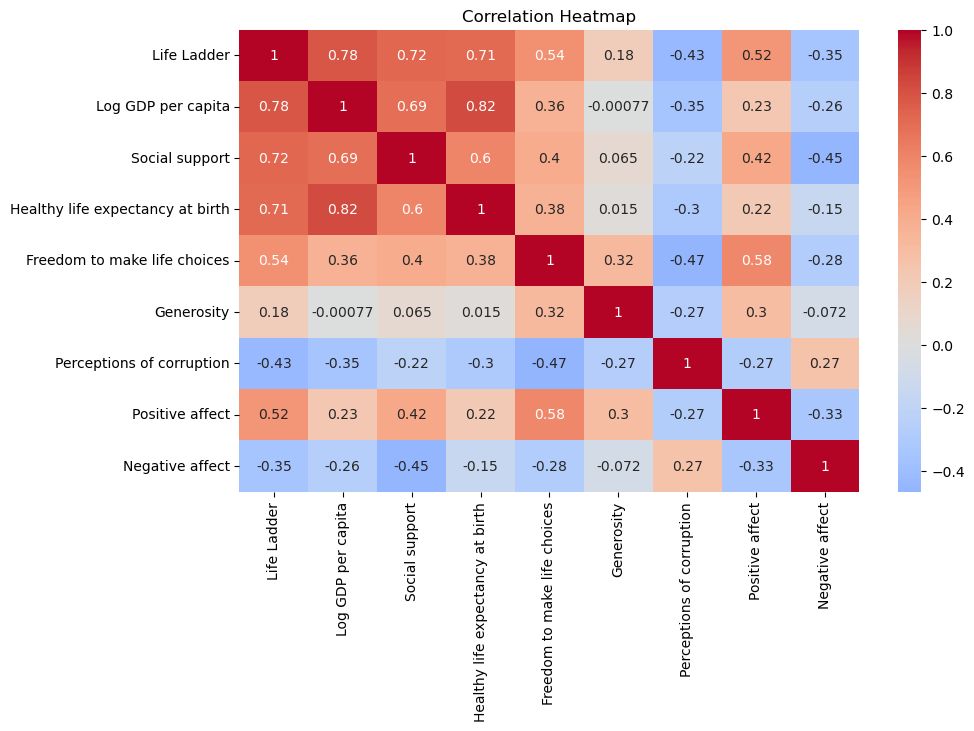

In [16]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


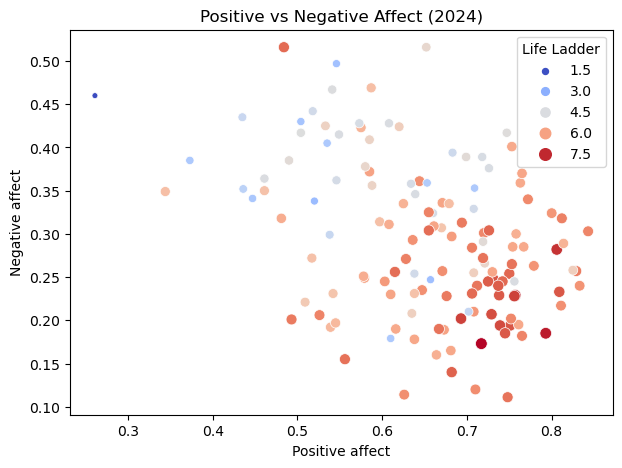

In [17]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [19]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.


In [20]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.


In [21]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [22]:
df['year'].value_counts().sort_index(ascending=True)

2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: year, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong).


In [23]:
# Sort so interpolation respects time
df = df.sort_values(['Country name', 'year']).copy()

# Pick numeric columns (optionally exclude 'year' from interpolation)
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = num_cols.drop('year', errors='ignore')

# Interpolate within each country, forward/backward to fill edges
df[num_cols] = (
    df.groupby('Country name', group_keys=False)[num_cols]
      .apply(lambda g: g.interpolate(limit_direction='both'))
)

#  If any numeric NaNs remain, fill with country means, then global means
df[num_cols] = (
    df.groupby('Country name', group_keys=False)[num_cols]
      .apply(lambda g: g.fillna(g.mean()))
      .fillna(df[num_cols].mean())
)

# Preview
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.


In [24]:
# Sort so interpolation respects time per country
df = df.sort_values(['Country name', 'year']).copy()

# Pick numeric columns (usually exclude 'year' from interpolation)
numeric_columns = (
    df.select_dtypes(include=['number'])
      .columns.drop('year', errors='ignore')
)

# Interpolate within each country and keep the original index/shape
filled_numeric = (
    df.groupby('Country name', group_keys=False)[numeric_columns]
      .apply(lambda g: g.interpolate(limit_direction='both'))
)

# fill any remaining NaNs: country mean -> global mean
filled_numeric = (
    df[['Country name']].join(filled_numeric)
      .groupby('Country name', group_keys=False)
      .apply(lambda g: g.fillna(g.mean()))
      .drop(columns=['Country name'])
      .fillna(filled_numeric.mean())
)

# Put the filled numbers back into df
df[numeric_columns] = filled_numeric

#  If you want a separate 'data' frame with country/year + numerics:
data = pd.concat(
    [df[['Country name', 'year']].reset_index(drop=True),
     df[numeric_columns].reset_index(drop=True)],
    axis=1
)

data.head(16)


/var/folders/yw/ltlm31rx1pzblj_k4g8y8tm00000gn/T/ipykernel_57710/1391878463.py:20: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/yw/ltlm31rx1pzblj_k4g8y8tm00000gn/T/ipykernel_57710/1391878463.py:20: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/yw/ltlm31rx1pzblj_k4g8y8tm00000gn/T/ipykernel_57710/1391878463.py:20: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


In [25]:
data.isna().sum()

Country name                        0
year                                0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.


In [26]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2363 non-null   float64
 4   Social support                    2363 non-null   float64
 5   Healthy life expectancy at birth  2363 non-null   float64
 6   Freedom to make life choices      2363 non-null   float64
 7   Generosity                        2363 non-null   float64
 8   Perceptions of corruption         2363 non-null   float64
 9   Positive affect                   2363 non-null   float64
 10  Negative affect                   2363 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


The categorical `Country name` needs to be ~~label encoded so that it can be handled numerically~~ dropped, as there's no point in training on it.


In [27]:
# data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
# data.sample(10)

data.drop('Country name', axis=1, inplace=True)

Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).


In [28]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 0 to 2358
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              1847 non-null   int64  
 1   Life Ladder                       1847 non-null   float64
 2   Log GDP per capita                1847 non-null   float64
 3   Social support                    1847 non-null   float64
 4   Healthy life expectancy at birth  1847 non-null   float64
 5   Freedom to make life choices      1847 non-null   float64
 6   Generosity                        1847 non-null   float64
 7   Perceptions of corruption         1847 non-null   float64
 8   Positive affect                   1847 non-null   float64
 9   Negative affect                   1847 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 158.7 KB


In [29]:
features_train = training.drop(['Life Ladder'], axis=1)
features_test = test.drop(['Life Ladder'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


Lastly, we need to ensure that our features are scaled; log GDP and life expectancy are both relatively large numbers compared to the other features and may have disproportionate impact on the model. We fit a StandardScaler on the just training features, because otherwise the scaler acts as a "hint" to the model during training (i.e. data leaks out of the test set), then we use it to transform both the features and target.


In [30]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [31]:
# For neural networks specifically, standardizing the target is often also a good idea--we can inverse transform to compare to other models
target_scaler = StandardScaler()
target_scaler.fit(target_train.values.reshape(-1,1))
target_train_scaled = target_scaler.transform(target_train.values.reshape(-1,1)).flatten()
target_test_scaled = target_scaler.transform(target_test.values.reshape(-1,1)).flatten()

# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:


### Baseline model


In [32]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.40089191963504917

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:


In [33]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 120, step=5) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 4, 25, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study() #direction="minimize" is a default parameter; we'd set to "maximum" if we had a metric where higher is better, such as accuracy for categorization
study.optimize(objective, n_trials=40)

[I 2025-10-05 09:36:10,887] A new study created in memory with name: no-name-c0c252e7-3045-4eb0-b269-919c2817c7fd
[I 2025-10-05 09:36:11,692] Trial 0 finished with value: 0.3439298145863437 and parameters: {'n_estimators': 45, 'max_depth': 18}. Best is trial 0 with value: 0.3439298145863437.
[I 2025-10-05 09:36:13,707] Trial 1 finished with value: 0.3419006693714349 and parameters: {'n_estimators': 110, 'max_depth': 25}. Best is trial 1 with value: 0.3419006693714349.
[I 2025-10-05 09:36:14,907] Trial 2 finished with value: 0.35209477335168415 and parameters: {'n_estimators': 110, 'max_depth': 9}. Best is trial 1 with value: 0.3419006693714349.
[I 2025-10-05 09:36:15,503] Trial 3 finished with value: 0.3445642036060954 and parameters: {'n_estimators': 45, 'max_depth': 11}. Best is trial 1 with value: 0.3419006693714349.
[I 2025-10-05 09:36:17,360] Trial 4 finished with value: 0.3392085545488106 and parameters: {'n_estimators': 85, 'max_depth': 12}. Best is trial 4 with value: 0.3392085

In [34]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 50, 'max_depth': 20}
At trial:  16
Mean absolute error:  0.3317512455060501

Hyperparameter importances:


{'max_depth': 0.7690837839400911, 'n_estimators': 0.2309162160599089}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.33; and the max_depth parameter had a bigger effect on the outcome of the forest than the n_estimators parameter did. Compared to the range of values, that's not too shabby!:


In [35]:
df['Life Ladder'].describe()

count    2363.000000
mean        5.483566
std         1.125522
min         1.281000
25%         4.647000
50%         5.449000
75%         6.323500
max         8.019000
Name: Life Ladder, dtype: float64

To really see Optuna in action, we can use a more complicated model: the neural network. Torch is a well-regarded library for setting those up.


In [36]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

device

device(type='cpu')

Torch calls its data structure 'tensors,' but it can only make them from numpy arrays rather than pandas series, so we need to do some conversion. The StandardScaler already converted our features to ndarray type, and with the targets we can just call `to_numpy()`:


In [37]:
features_train_tensor = torch.from_numpy(features_train).float().to(device)
features_test_tensor = torch.from_numpy(features_test).float().to(device)
target_train_tensor = torch.from_numpy(target_train_scaled).float().to(device)
target_test_tensor = torch.from_numpy(target_test_scaled).float().to(device)
print(features_train_tensor.shape)
target_train_tensor.shape

torch.Size([1847, 9])


torch.Size([1847])

Now we have to do something a little unique: we need to create a Torch neural network that also integrates Optuna's functionality.


In [38]:
def define_nn(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_neurons = features_train_tensor.shape[1] #one input neuron for each feature

    activation_name = trial.suggest_categorical("activation_function", ["ReLU", "LeakyReLU", "SiLU"])
    activation = getattr(nn, activation_name) #nn.ReLU(), nn.LeakyReLU(), or nn.SiLU() respectively

    for i in range(n_layers):
        out_neurons = trial.suggest_int("n_units_layer{}".format(i), 3, 9)
        layers.append(nn.Linear(in_neurons, out_neurons))
        layers.append(activation())
        drop_p = trial.suggest_float("dropout_layer{}".format(i), 0.12, 0.5)
        layers.append(nn.Dropout(drop_p))

        in_neurons = out_neurons
    layers.append(nn.Linear(in_neurons, 1))

    return nn.Sequential(*layers)

This function defines a Torch neural network where all of the following is determined by Optuna's trials:

- the number of hidden layers (1 to 3 inclusive--the `range()` in the for loop adds the hidden layers, then we manually add one last layer without Dropout or an activation function at the end)
- which activation function to use for the hidden layers (there are many, with ReLU being a common default to introduce nonlinearity to a model)
- how many neurons to put in each layer (3 to 9 inclusive)--note that smaller layers can precede larger ones or vice-versa
- what percentage of neurons are frozen by the dropout layer (a technique for preventing overfitting), from 12% to 50%

Now we need our counterpart to `objective()` from the previous model. In this we'll introduce two more things for Optuna to play with: which optimizer to use, and the learning rate.


In [39]:
epochs = 500
def objective_nn(trial):
    model = define_nn(trial).to(device)

    #optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"])
    lr = trial.suggest_float("learning_rate", 0.00001, 0.1, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr) #equivalent to calling torch.Adam(model.parameters(), lr=lr), generalized for all three options

    loss_fn = nn.L1Loss()
    #train the model
    for epoch in range(epochs):
        #training
        model.train() # enables dropout if model.eval() is triggered
        optimizer.zero_grad()
        pred = model(features_train_tensor)

        
        #scaled loss for backpropagation
        output = loss_fn(pred.squeeze(), target_train_tensor)
        output.backward()
        
        optimizer.step()

        #validation
        model.eval() #disables dropout
        with torch.no_grad():
            val_pred = model(features_test_tensor)
            # unscaled validation loss for reporting; have to convert back to numpy ndarrays for this
            unscaled_pred = target_scaler.inverse_transform(val_pred.cpu().detach().numpy())
            unscaled_target = target_scaler.inverse_transform(target_test_tensor.cpu().reshape(-1, 1).numpy())
            val_loss = loss_fn(
                #now we need to convert back to tensors
                torch.tensor(unscaled_pred.squeeze()), 
                torch.tensor(unscaled_target.squeeze())
                )

        #report to optuna/pruning check
            trial.report(val_loss, step=epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    return val_loss


Our neural network alternates between a round of training and a round of validation, reporting each validation to Optuna to see if it should be pruned.

Let's run and see how it goes:


In [1]:
nn_study = optuna.create_study()
nn_study.optimize(objective_nn, n_trials=100)

NameError: name 'optuna' is not defined

In [55]:
print('Best RF parameters: ', nn_study.best_params)
print('At trial: ', nn_study.best_trial.number)
print('Mean absolute error: ', nn_study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=nn_study) #evaluator is the default, FanovaImportanceEvaluator
importances

Best RF parameters:  {'n_layers': 1, 'activation_function': 'SiLU', 'n_units_layer0': 9, 'dropout_layer0': 0.35053354631764827, 'optimizer': 'AdamW', 'learning_rate': 0.04246170266674588}
At trial:  60
Mean absolute error:  0.3778667151927948

Hyperparameter importances:


{'learning_rate': np.float64(0.2493201575202803),
 'dropout_layer0': np.float64(0.23591516836217205),
 'n_layers': np.float64(0.20077777771768687),
 'optimizer': np.float64(0.20009997209902228),
 'activation_function': np.float64(0.06419984026814193),
 'n_units_layer0': np.float64(0.049687084032696505)}

In [6]:
# prediction function to calculate the happiness score
df = world_happiness_df.copy()
def predict_happiness(country_name):
    """
    Predicts happiness score (Life Ladder) for a given country
    based on its most recent available data.
    """
    # Get the most recent record for the selected country

    country_data = df[df['Country name'] == country_name].sort_values('year', ascending=False).head(1)

    if country_data.empty:
        print(f"❌ Country '{country_name}' not found in dataset.")
        return

    # Prepare the input data (features only)
    X_country = country_data[]
    X_country_scaled = scaler.transform(X_country)

    # Predict using the trained model
    prediction = lr.predict(X_country_scaled)[0]

    print(f"🌍 Country: {country_name}")
    print(f"🗓️ Year: {int(country_data['year'].values[0])}")
    print(f"🔮 Predicted Happiness Score: {prediction:.2f}")
    return prediction

# Example usage
predict_happiness("India")
predict_happiness("Finland")
predict_happiness("United States")


NameError: name 'data' is not defined

We did eventually find a neural network architecture that outperformed the linear regression, but not the random forest. After 100 trials of 500 epochs, we've learned the following:

- The ideal learning rate was about 0.42, which was the thing with the biggest impact on the results
- The second-biggest impact was from the dropout percentage, which was 35% (or three of our nine features)
- The number of layers and the optimizer also had a significant impact, with a single layer working best given our low feature count and AdamW being the optimizer for the strongest run
- The specific activation function and the number of units in the hidden layer were relatively unimportant (in this set of trials SiLU and 9 units, respectively, but may change if trials are rerun).


### Conclusion:

Our analysis of the World Happiness Report (2005–2024) shows clear, consistent patterns:

- Top drivers of happiness are economic prosperity (log GDP per capita), social support, and healthy life expectancy.

- Governance quality matters: higher perceived corruption reliably associates with lower happiness.

- Freedom to make life choices adds measurable uplift, while generosity and short-term affect metrics contribute modestly and less consistently across countries.

- Geographic patterns persist—Nordic countries lead, while parts of Sub-Saharan Africa and South Asia score lower—yet outliers prove that strong social support and governance can offset limited wealth.

- Policy takeaways: invest in public health, strengthen social safety nets, improve institutions and anti-corruption measures, and expand personal freedoms—these levers show the greatest return for national well-being.

- Limitations: scores are self-reported and observational; correlations don’t prove causality, and some countries/years have missing or uneven coverage. Future work should incorporate panel/causal methods, regional controls, and additional governance/inequality features.
